In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [1]:
# hide
# from utils import *
# setup_chapter()

NameError: name 'setup_chapter' is not defined

Одной из самых удивительных особенностей языковых моделей, основанных на трансформерах, является их способность генерировать текст, который почти неотличим от текста, написанного людьми. Известным примером является OpenAFs GPT-2.
В шокирующем открытии ученые обнаружили стадо единорогов, живущих в отдаленной, ранее неисследованной долине в Андах. Еще более удивительным для исследователей был тот факт, что единороги прекрасно говорили по-английски.
смог создать убедительную новостную статью о говорящих единорогах:
Ученый назвал население по имени Овидия; Единорог. Эти четырехрогие серебристо-белые единороги ранее были неизвестны науке. Теперь, по прошествии почти двух столетий, тайна того, что вызвало это странное явление, наконец-то раскрыта. Доктор Хорхе Перес, эволюционный биолог из Университета Ла-Паса, и несколько его товарищей исследовали Анды, когда обнаружили небольшую долину, в которой не было ни животных, ни людей. Перес заметил, что в долине было что-то похожее на естественный фонтан, окруженный двумя вершинами скал и серебристого снега. Затем Перес и остальные отправились дальше в долину. «К тому времени, когда мы достигли вершины одного из пиков, вода выглядела голубой, с несколькими кристаллами на вершине», — сказал Перес. Перес и его друзья были поражены, увидев стадо единорогов. Этих существ можно было увидеть с воздуха, не двигаясь слишком сильно, чтобы увидеть их — они были так близко, что могли дотронуться до своих рогов. Изучая этих причудливых существ, ученые обнаружили, что они также говорят на довольно обычном английском языке.
Что делает этот пример таким замечательным, так это то, что он был способности, которые могут быть активированы с помощью различных подсказок ввода.
На рисунке 5.1  показано, как языковые модели иногда подвергаются предварительному обучению последовательностям задач, в которых им необходимо предсказать следующие лексемы, основанные только на контексте, такие как сложение, расшифровка слов и перевод. Это позволяет им эффективно передавать эти знания во время тонкой настройки или (если модель достаточно велика) во время вывода. Эти задачи не выбираются заранее, а возникают естественным образом в огромных корпусах, используемых для обучения языковых моделей с миллиардами параметров.

# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="images/chapter05_lm-meta-learning.png" id="lm-meta-learning"/>

Способность трансформеров генерировать реалистичный текст привела к появлению широкого спектра приложений, таких как InferKit, Write With Transformer, AI Dungeon и диалоговых агентов, таких  как Meena от Google, которые могут даже рассказывать банальные анекдоты, как показано на рисунке 

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="images/chapter05_meena.png" id="meena"/>

Далее мы будем использовать GPT-2, чтобы проиллюстрировать, как работает генерация текста для языковых моделей, и рассмотрим, как различные стратегии декодирования

## Проблема создания связного текста
Ранее мы сосредотачивались на решении задач НЛП с помощью комбинации предварительного обучения и контролируемой тонкой настройки. Как мы видели, для заголовков конкретных задач, таких как последовательность или классификация маркеров, создание прогнозов довольно просто; Модель выдает некоторые логиты, и мы либо берем максимальное значение для получения прогнозируемого класса, либо применяем функцию softmax для получения прогнозируемых вероятностей для каждого класса. Напротив, преобразование вероятностных выходных данных модели в текст требует декодирования который создает несколько проблем, уникальных для генерации текста:
•	Декодирование выполняется итеративно и, таким образом, требует значительно больше вычислительных ресурсов, чем простая передача входных данных один раз через прямой проход модели.
•	Качество  и разнообразие генерируемого текста зависят от выбора метода декодирования и связанных с ним гиперпараметров. 
Чтобы понять, как работает этот процесс декодирования, давайте начнем с изучения того, как GPT-2 предварительно обучается и впоследствии применяется для генерации текста.
Как и другие модели авторегрессионного или причинно-следственного языка, GPT-2 предварительно обучен оценивать вероятность P(y |x) последовательности лексем, встречающегося в тексте, при наличии некоторой начальной подсказки или контекстной последовательности, Поскольку непрактично получить достаточное количество обучающих данных для непосредственной оценки P(y |x), обычно используется цепное правило вероятности, чтобы разложить его на множители как произведение условных вероятностей. Именно из этих условных вероятностей мы интуитивно понимаем, что авторегрессионное моделирование языка сводится к предсказанию каждого слова с учетом предшествующих слов в предложении; Это именно то, что описывает вероятность в правой части предыдущего уравнения. Обратите внимание, что эта цель предварительного обучения сильно отличается от цели BERT, которая использует как прошлый, так  и будущий контексты для прогнозирования замаскированной лексемы. К этому моменту вы, возможно, уже догадались, как мы можем адаптировать эту следующую задачу прогнозирования маркеров для генерации текстовых последовательностей произвольной длины. Как показано на рисунке, мы начинаем с запроса типа "Transformers are the" и используем модель для прогнозирования следующей лексемы. После того, как мы определили следующую лексему, мы добавляем ее в приглашение, а затем используем новую последовательность ввода для создания другой. Мы делаем это до тех пор, пока не достигнем специального маркера конца последовательности или предопределенной максимальной длины.
 


## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="images/chapter05_text-generation.png" id="text-generation"/> 

Непосредственное нахождение y потребовало бы оценки каждой возможной последовательности с помощью языковой модели. Поскольку не существует алгоритма, который мог бы сделать это за разумное время, мы полагаемся на аппроксимации. Далее мы рассмотрим некоторые из этих приближений и постепенно перейдем к более умным и сложным алгоритмам, которые можно использовать.  

## Greedy Search Decoding

Простейшим методом декодирования для получения дискретных токенов из непрерывного вывода модели является жадный выбор токена с наибольшей вероятностью на каждом временном шаге:

Чтобы увидеть, как работает жадный поиск, давайте начнем с загрузки версии GPT-2 с 1,5 миллиардами параметров с головкой моделирования языка:

In [1]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Теперь давайте сгенерируем текст! Хотя Transformers предоставляет  функцию generateQ для авторегрессионных моделей, таких как GPT-2, мы сами реализуем этот метод декодирования, чтобы увидеть, что происходит под капотом. Для разогрева мы воспользуемся тем же итеративным подходом, показанным на рисунке: мы будем использовать "Transformers are the" в качестве входного приглашения и запустим декодирование для восьми временных шагов. На каждом временном шаге мы выбираем логиты модели для последней лексемы в приглашении и оборачиваем их softmax, чтобы получить распределение вероятностей. Затем мы выбираем следующий токен с наибольшей вероятностью, добавляем его во входную последовательность и запускаем процесс снова.

Следующий код выполняет эту работу, а также сохраняет пять наиболее вероятных маркеров на каждом временном шаге, чтобы мы могли визуализировать альтернативы:

In [2]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

2023-11-23 20:51:20.872806: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 20:51:21.152950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 20:51:21.153153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 20:51:21.186186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 20:51:21.256146: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 20:51:21.257036: I tensorflow/core/platform/cpu_feature_guard.cc:1

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.29%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.27%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [3]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most popular toy line in the world,


С помощью этого простого метода мы смогли сгенерировать предложение «Трансформеры — самая популярная линейка игрушек в мире». Интересно, что это указывает на то, что GPT-2 усвоила некоторые знания о медиафраншизе «Трансформеры», которая была создана двумя компаниями по производству игрушек (Hasbro и Takara Tomy). Мы также можем видеть другие возможные продолжения на каждом шаге, что показывает итеративный характер генерации текста. В отличие от других задач, таких как классификация последовательностей, где для создания прогнозов достаточно одного прямого прохода, при создании текста нам нужно декодировать выходные маркеры по одному.
Реализовать жадный поиск было не так уж сложно, но мы захотим использовать встроенную  функцию generate() из - Transformers для изучения более сложных методов декодирования. Убедитесь, что выборка отключена (по умолчанию она отключена, если в конкретной конфигурации модели, из которой загружается контрольная точка, не указано иное) и укажите max_new_tokens количества вновь сгенерированных токенов:


In [4]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


Что ж, первые несколько предложений сильно отличаются от примера с OpenAI и забавно связаны с тем, что открытие приписывается разным университетам! Мы также можем увидеть один из основных недостатков жадного декодирования поиска: оно имеет тенденцию создавать повторяющиеся выходные последовательности, что, безусловно, нежелательно в новостной статье. Это распространенная проблема жадных поисковых алгоритмов, которые могут не дать вам оптимального решения; В контексте декодирования они могут пропустить последовательности слов, общая вероятность которых выше только потому, что словам с высокой вероятностью предшествуют слова с низкой вероятностью.

## Beam Search Decoding

Вместо того, чтобы декодировать токен с наибольшей вероятностью на каждом шаге, поиск по лучу отслеживает наиболее вероятные следующие лексемы top-b, где b — это количество лучей или частичных гипотез. Следующий набор балок выбирается путем рассмотрения всех возможных расширений следующего токена существующего набора и выбора b наиболее вероятных расширений. Процесс повторяется до тех пор, пока мы не достигнем максимальной длины или токена EOS, и выбирается наиболее вероятная последовательность путем ранжирования  b-лучей в соответствии с их логарифмическими вероятностями. Пример поиска луча показан на рисунке 

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="images/chapter05_beam-search.png" id="beam-search"/> 

Почему мы оцениваем последовательности, используя логарифмические вероятности, а не сами вероятности? То есть вычисление общей вероятности последовательности P(yi, y2,	yt) включает в себя вычисление продукт условного
вероятности P(yt,yt,x) является одной из причин. Поскольку каждая условная вероятность обычно представляет собой небольшое число в диапазоне [0,1], взятие их произведения может привести к общей вероятности, которая может легко занизиться. Это означает, что компьютер больше не может точно представить результат расчета. 

In [7]:
0.5 ** 1024

5.562684646268003e-309

Это приводит к численной нестабильности, так как мы сталкиваемся с недостаточным потоком. Этого можно избежать, вычислив связанное с ним слагаемое — логарифмическую вероятность. Другими словами, произведение вероятностей, которое мы видели ранее, становится суммой логарифмических вероятностей, которая с гораздо меньшей вероятностью столкнется с численными неустойчивостями. Например, вычисление логарифмической вероятности того же примера, что и раньше, дает:

In [8]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

Это число, с которым мы можем легко справиться, и этот подход по-прежнему работает для гораздо меньших чисел. Поскольку мы хотим сравнивать только относительные вероятности, мы можем сделать это непосредственно с логарифмическими вероятностями.
Давайте вычислим и сравним логарифмические вероятности текстов, сгенерированных жадным и лучевым поиском, чтобы увидеть, может ли лучевой поиск улучшить общую вероятность. Поскольку модели ~ Transformers возвращают ненормализованные логиты для следующей лексемы с учетом входных токенов, нам сначала нужно нормализовать логиты, чтобы создать распределение вероятностей по всему словарю для каждой лексемы в последовательности. Затем нам нужно выбрать только те вероятности маркеров, которые присутствовали в последовательности. Следующие шаги реализуются следующей функцией:


In [9]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [10]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [11]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [12]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains. Even more surprising to the researchers was the fact
that the unicorns spoke perfect English

log-prob: -55.23


In [13]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of scientists from the University of
California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the
area when they came across the herd. They were surprised to find that they were
able to converse with the animals in English, even though they had never seen a
unicorn in person before. The researchers were

log-prob: -93.12


## Sampling Methods

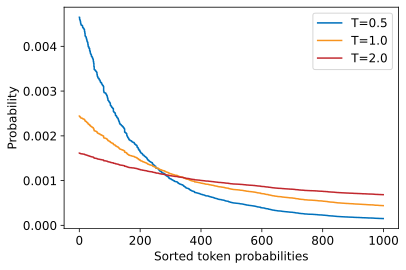

In [14]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [15]:
# hide
torch.manual_seed(42);

In [16]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


While the station aren protagonist receive Pengala nostalgiates tidbitRegarding
Jenny loclonju AgreementCON irrational �rite Continent seaf A jer Turner
Dorbecue WILL Pumpkin mere Thatvernuildagain YoAniamond disse *
Runewitingkusstemprop});b zo coachinginventorymodules deflation press
Vaticanpres Wrestling chargesThingsctureddong Ty physician PET KimBi66 graz Oz
at aff da temporou MD6 radi iter


In [17]:
# hide
torch.manual_seed(42);

In [18]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists were searching for the source of the mysterious sound, which was
making the animals laugh and cry.


The unicorns were living in a remote valley in the Andes mountains

'When we first heard the noise of the animals, we thought it was a lion or a
tiger,' said Luis Guzman, a researcher from the University of Buenos Aires,
Argentina.


'But when


## Top-k and Nucleus Sampling

In [19]:
# hide
torch.manual_seed(42);

In [20]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [21]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

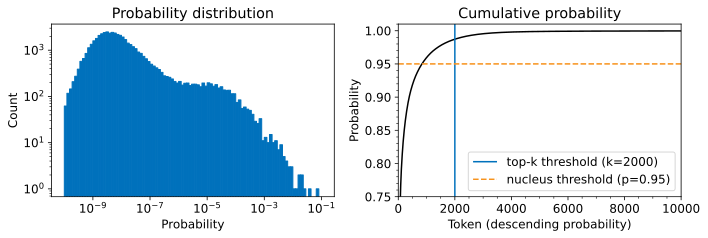

In [22]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [23]:
# hide
torch.manual_seed(42);

In [24]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the
border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire
Naturelle)

The researchers came across about 50 of the animals in the valley. They had
lived in such a remote and isolated area at that location for nearly a thousand
years that


In [25]:
# hide
torch.manual_seed(42);

In [26]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came to the conclusion that
the herd are descendants of a prehistoric herd that lived in Argentina about
50,000 years ago.


According to the scientific analysis, the first humans who migrated to South
America migrated into the Andes Mountains from South Africa and Australia, after
the last ice age had ended.


Since their migration, the animals have been adapting to


## Which Decoding Method Is Best?

## Conclusion

In [27]:
import torch
torch.cuda.is_available()

True

In [28]:
import tensorflow as tf

# Проверяем доступные GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Available: {gpu}")
else:
    print("No GPU available.")


GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-11-23 08:30:52.934573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 08:30:52.941254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 08:30:52.941711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
